In [1]:
import os
import pandas as pd 
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import shutil 
import torch
import random
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

In [2]:
import torch

# Check if CUDA is available (should be False for Apple Silicon)
print(f"CUDA available: {torch.cuda.is_available()}")

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

CUDA available: False
PyTorch version: 2.4.0
Using device: mps


### Preprocessing

Gathering all the images and storing them in a single folder.

In [114]:
def gather_jpg_images(src_base_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Traverse through all subdirectories
    for root, dirs, files in os.walk(src_base_dir):
        for file in files:
            if file.lower().endswith('.jpg'):
                # Construct full file path
                src_file_path = os.path.join(root, file)
                dest_file_path = os.path.join(dest_dir, file)
                
                # Copy image to destination directory
                shutil.copy(src_file_path, dest_file_path)

# Define paths
src_base_directory = 'data/img/'  
dest_directory = 'data/images'  

# Gather images
gather_jpg_images(src_base_directory, dest_directory)

Extracting only the image names instead of the full path of the images.

In [120]:
def process_annotations(input_file, output_dir):
    """
    Process the annotation file to extract image names and annotations,
    and save them in a clean format in the output directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(input_file, 'r') as file:
        lines = file.readlines()

    image_annotations = {}
    current_image = None

    # Extract image names and their annotations
    for line in lines:
        line = line.strip()
        if line.startswith('#'):
            # Extract the image name from the line
            image_path = line[1:].strip()  # Remove the '#' and any leading/trailing whitespace
            image_name = os.path.basename(image_path)  # Extract the filename from the path
            current_image = image_name
            image_annotations[current_image] = []
        elif line and current_image is not None:
            # Collect annotations for the current image
            image_annotations[current_image].append(line)

    # Write the results to the output files
    for image_name, annotations in image_annotations.items():
        output_file_path = os.path.join(output_dir, image_name.replace('.jpg', '.txt'))
        with open(output_file_path, 'w') as file:
            for annotation in annotations:
                file.write(f'{annotation}\n')

In [121]:
# Define paths
annotation_file_path = 'data/label.txt'  
output_annotations_dir = 'data/annotations'  

# Process and save annotations
process_annotations(annotation_file_path, output_annotations_dir)

### Splitting the data into train and val dataset

In [124]:
def create_split_folders(base_dir, splits):
    """
    Create directories for train, val, and test splits.
    """
    for split in splits:
        os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(base_dir, split, 'annotations'), exist_ok=True)

def move_files(image_files, split, base_image_dir, base_annotation_dir, target_base_dir):
    """
    Move image and annotation files to the appropriate split directory.
    """
    for img_file in image_files:
        shutil.copy(os.path.join(base_image_dir, img_file), os.path.join(target_base_dir, split, 'images', img_file))
        annotation_file = img_file.replace('.jpg', '.txt')
        if os.path.exists(os.path.join(base_annotation_dir, annotation_file)):
            shutil.copy(os.path.join(base_annotation_dir, annotation_file), os.path.join(target_base_dir, split, 'annotations', annotation_file))

def split_data(image_dir, annotation_dir, output_base_dir, split_ratios=(0.7, 0.2, 0.1)):
    """
    Split images and annotations into train, val, and test datasets.
    """
    # Create split directories
    create_split_folders(output_base_dir, ['train', 'val', 'test'])

    # List all image files
    all_images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    # Split data
    train_images, temp_images = train_test_split(all_images, test_size=(split_ratios[1] + split_ratios[2]), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

    # Move files to corresponding directories
    move_files(train_images, 'train', image_dir, annotation_dir, output_base_dir)
    move_files(val_images, 'val', image_dir, annotation_dir, output_base_dir)
    move_files(test_images, 'test', image_dir, annotation_dir, output_base_dir)

In [125]:
# Define directories
image_dir = 'data/images'  # Directory containing images
annotation_dir = 'data/annotations/'  # Directory containing filtered annotations
output_base_dir = 'data/split_data'  # Base directory for split datasets

In [126]:
# Split the data
split_data(image_dir, annotation_dir, output_base_dir)


### Cleaning of the data

Deleting the annotations for which images don't exist in the dataset and vice-versa.

In [132]:
def delete_orphaned_files(images_dir, annotations_dir):
    """
    Delete annotation files for which the corresponding image does not exist,
    and delete image files for which the corresponding annotation does not exist.
    """
    # Get list of image files
    image_files = {f for f in os.listdir(images_dir) if f.endswith('.jpg')}
    
    # Get list of annotation files
    annotation_files = {f for f in os.listdir(annotations_dir) if f.endswith('.txt')}
    
    # Delete orphaned annotation files
    for ann_file in annotation_files:
        img_file = ann_file.replace('.txt', '.jpg')
        if img_file not in image_files:
            os.remove(os.path.join(annotations_dir, ann_file))
            print(f"Deleted orphaned annotation: {ann_file}")
    
    # Delete orphaned image files
    for img_file in image_files:
        ann_file = img_file.replace('.jpg', '.txt')
        if ann_file not in annotation_files:
            os.remove(os.path.join(images_dir, img_file))
            print(f"Deleted orphaned image: {img_file}")

def clean_files_for_all_splits(base_dir):
    """
    Clean orphaned annotations and images for train, val, and test splits.
    """
    splits = ['train', 'val', 'test']
    for split in splits:
        images_dir = os.path.join(base_dir, split, 'images')
        annotations_dir = os.path.join(base_dir, split, 'annotations')
        print(f"Processing {split} split...")
        delete_orphaned_files(images_dir, annotations_dir)

In [ ]:
# Base directory containing train, val, and test folders
base_dir = 'data/split_data/'

# Run the function
clean_files_for_all_splits(base_dir)

### Displaying some images

In [144]:
def load_annotations(ann_file):
    """
    Load annotations from a file.
    Format: x_min y_min x_max y_max
    """
    boxes = []
    with open(ann_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 4:
                x_min, y_min, x_max, y_max = map(float, parts)
                boxes.append((x_min, y_min, x_max, y_max))
    return boxes

def draw_boxes_on_image(image, boxes):
    """
    Draw bounding boxes on an image.
    """
    for (x_min, y_min, x_max, y_max) in boxes:
        # Draw rectangle using pixel coordinates
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    return image

def display_images_with_boxes(base_dir, split, num_images=3):
    """
    Display images with bounding boxes from a specified split directory using matplotlib.
    """
    image_dir = os.path.join(base_dir, split, 'images')
    annotation_dir = os.path.join(base_dir, split, 'annotations')

    # Get list of images
    images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    # Randomly select images
    sample_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    
    for idx, img_file in enumerate(sample_images):
        img_path = os.path.join(image_dir, img_file)
        ann_path = os.path.join(annotation_dir, img_file.replace('.jpg', '.txt'))
        
        # Load image and annotations
        image = cv2.imread(img_path)
        boxes = load_annotations(ann_path)
        
        # Convert image from BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw boxes on image
        image_with_boxes = draw_boxes_on_image(image_rgb, boxes)
        
        # Plot image
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image_with_boxes)
        plt.title(img_file)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Displaying train images:


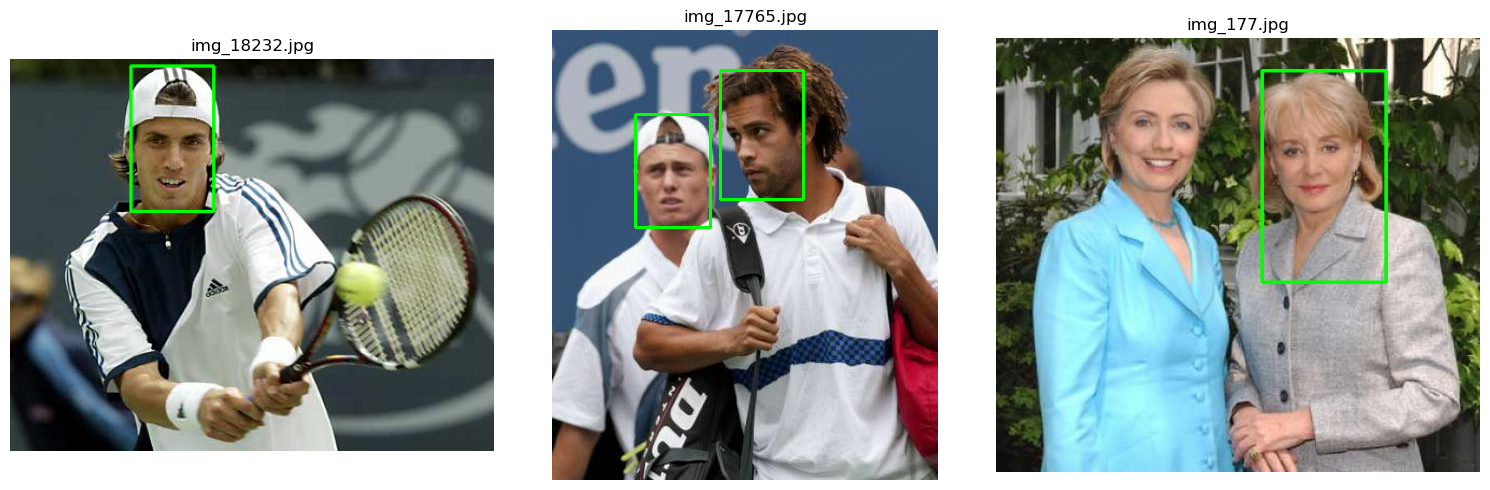

In [151]:
# Directories
base_dir = 'data/split_data'  

# Display images
for split in ['train']:
    print(f"Displaying {split} images:")
    display_images_with_boxes(base_dir, split)

# Model :- YOLO

### Converting the annotations for YOLO model

In [153]:

def convert_to_yolo_format(image_folder, annotation_folder, output_folder):
    """
    Convert annotations to YOLO format.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for ann_file in os.listdir(annotation_folder):
        if ann_file.endswith('.txt'):
            img_file = ann_file.replace('.txt', '.jpg')
            img_path = os.path.join(image_folder, img_file)
            ann_path = os.path.join(annotation_folder, ann_file)
            
            # Check if image exists
            if not os.path.isfile(img_path):
                continue
            
            # Read image dimensions
            img = cv2.imread(img_path)
            height, width = img.shape[:2]
            
            output_ann_path = os.path.join(output_folder, ann_file)
            with open(ann_path, 'r') as f_in, open(output_ann_path, 'w') as f_out:
                for line in f_in:
                    x_min, y_min, x_max, y_max = map(float, line.strip().split())
                    
                    # Convert to YOLO format
                    x_center = (x_min + x_max) / 2 / width
                    y_center = (y_min + y_max) / 2 / height
                    bbox_width = (x_max - x_min) / width
                    bbox_height = (y_max - y_min) / height
                    
                    # Assume class_id 0, adjust according to your needs
                    f_out.write(f"0 {x_center} {y_center} {bbox_width} {bbox_height}\n")


In [156]:
# Convert annotations for train and val datasets
convert_to_yolo_format('data/split_data/train/images', 'data/split_data/train/annotations', 'data/split_data/yolo_train_annotations')
convert_to_yolo_format('data/split_data/val/images', 'data/split_data/val/annotations', 'data/split_data/yolo_val_annotations')
convert_to_yolo_format('data/split_data/test/images', 'data/split_data/test/annotations', 'data/split_data/yolo_test_annotations')

# Model :- YOLO

Model is trained in the terminal.

### Visualize Training Metrics

### After 50 epochs with yolo5s weights and image size 640

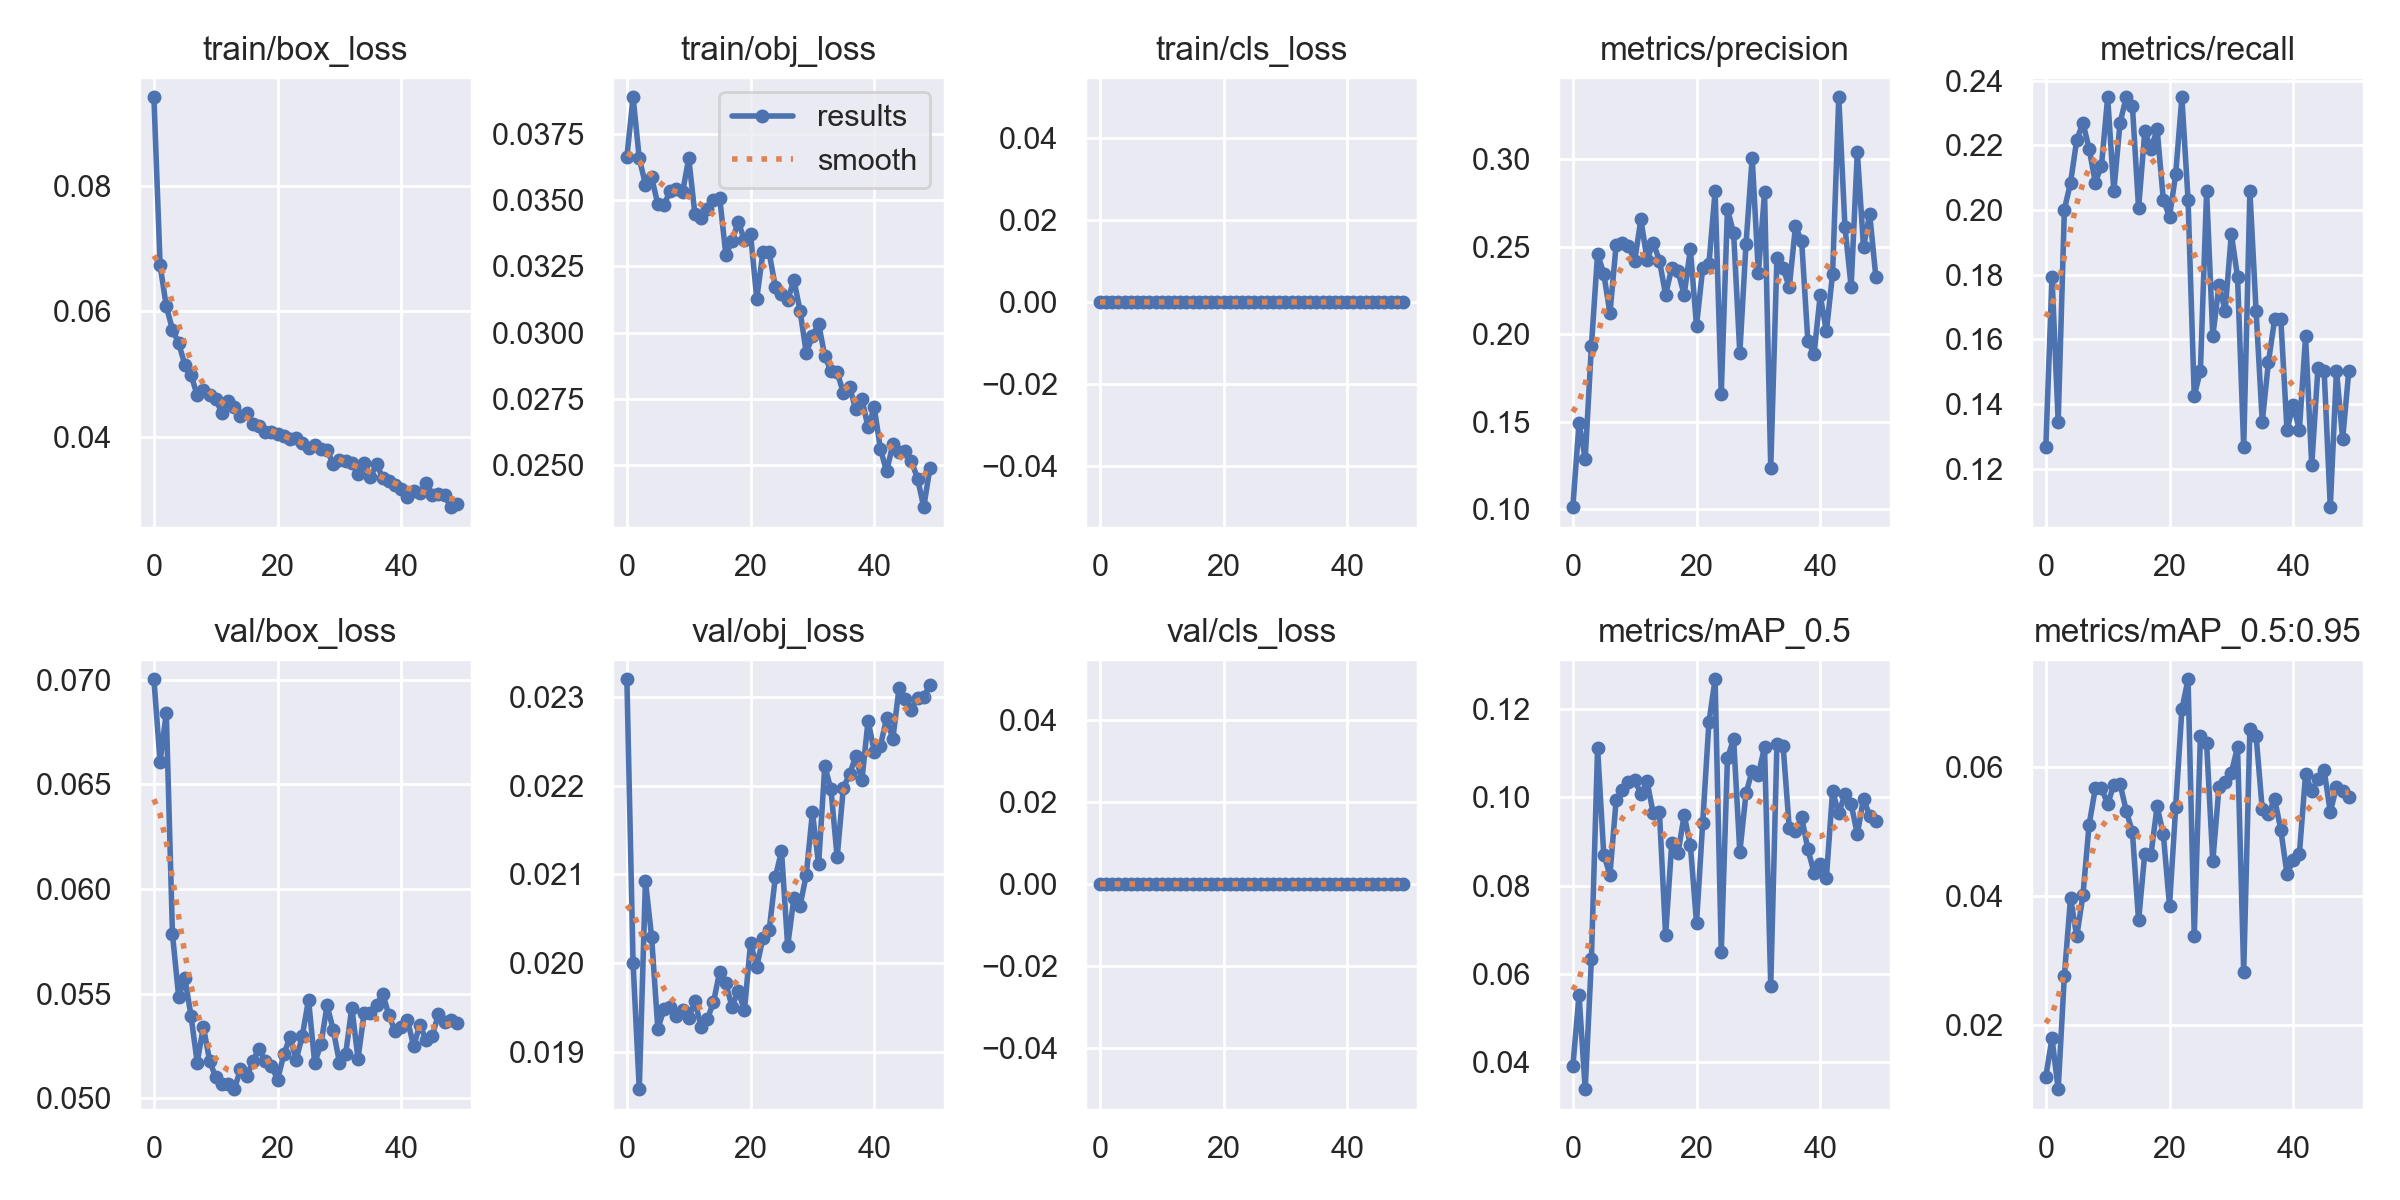

In [2]:
from IPython.display import Image, display

# Display the results.png image
display(Image(filename='yolov5/runs/train/exp5/results.png'))

In [23]:
print(os.getcwd())

/Users/ojas/Developer/AI/Projects/face_detection


In [2]:
import os

# Change to the YOLOv5 directory
os.chdir('yolov5')


In [11]:
os.chdir('..')


In [5]:
# Set up the path to your test images
test_images = 'test/images/'
weights_path = 'runs/train/exp5/weights/best.pt'

### Test Images

detect: weights=['runs/train/exp5/weights/best.pt'], source=test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.14 torch-2.4.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/152 /Users/ojas/Developer/AI/Projects/face_detection/yolov5/test/images/img_1000.jpg: 640x448 1 face, 46.4ms
image 2/152 /Users/ojas/Developer/AI/Projects/face_detection/yolov5/test/images/img_1026.jpg: 640x512 (no detections), 50.7ms
image 3/152 /Users/ojas/Developer/AI/Projects/face_detection/yolov5/test/images/img_1030.jpg: 640x480 1 face, 42.5ms
image 4

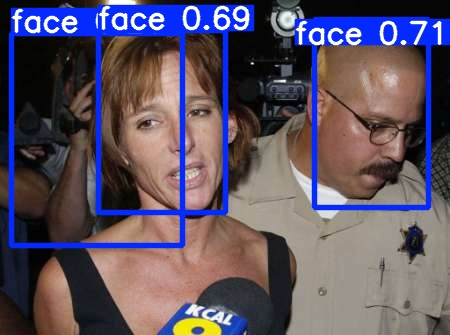

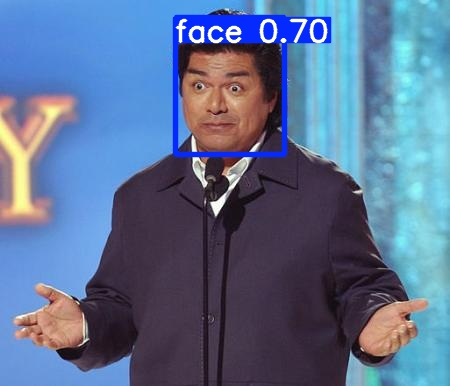

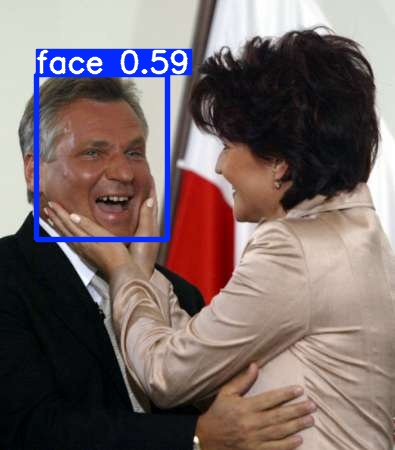

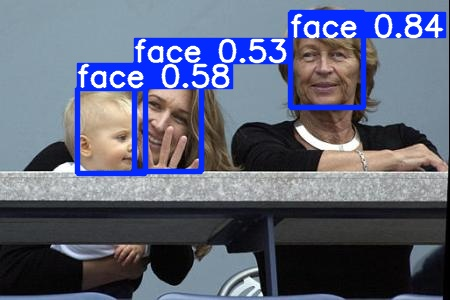

In [9]:
from pathlib import Path
from IPython.display import Image, display



# Run inference
!python detect.py --source {test_images} --weights {weights_path} --img 640 --conf 0.25 --save-txt --save-conf

# Display the inference results
result_dir = Path('runs/detect/exp5')
i = 0 
for img_path in result_dir.glob('*.jpg'):
    if(i==4): 
        break
    i += 1
    display(Image(filename=img_path))

### Resulting Images

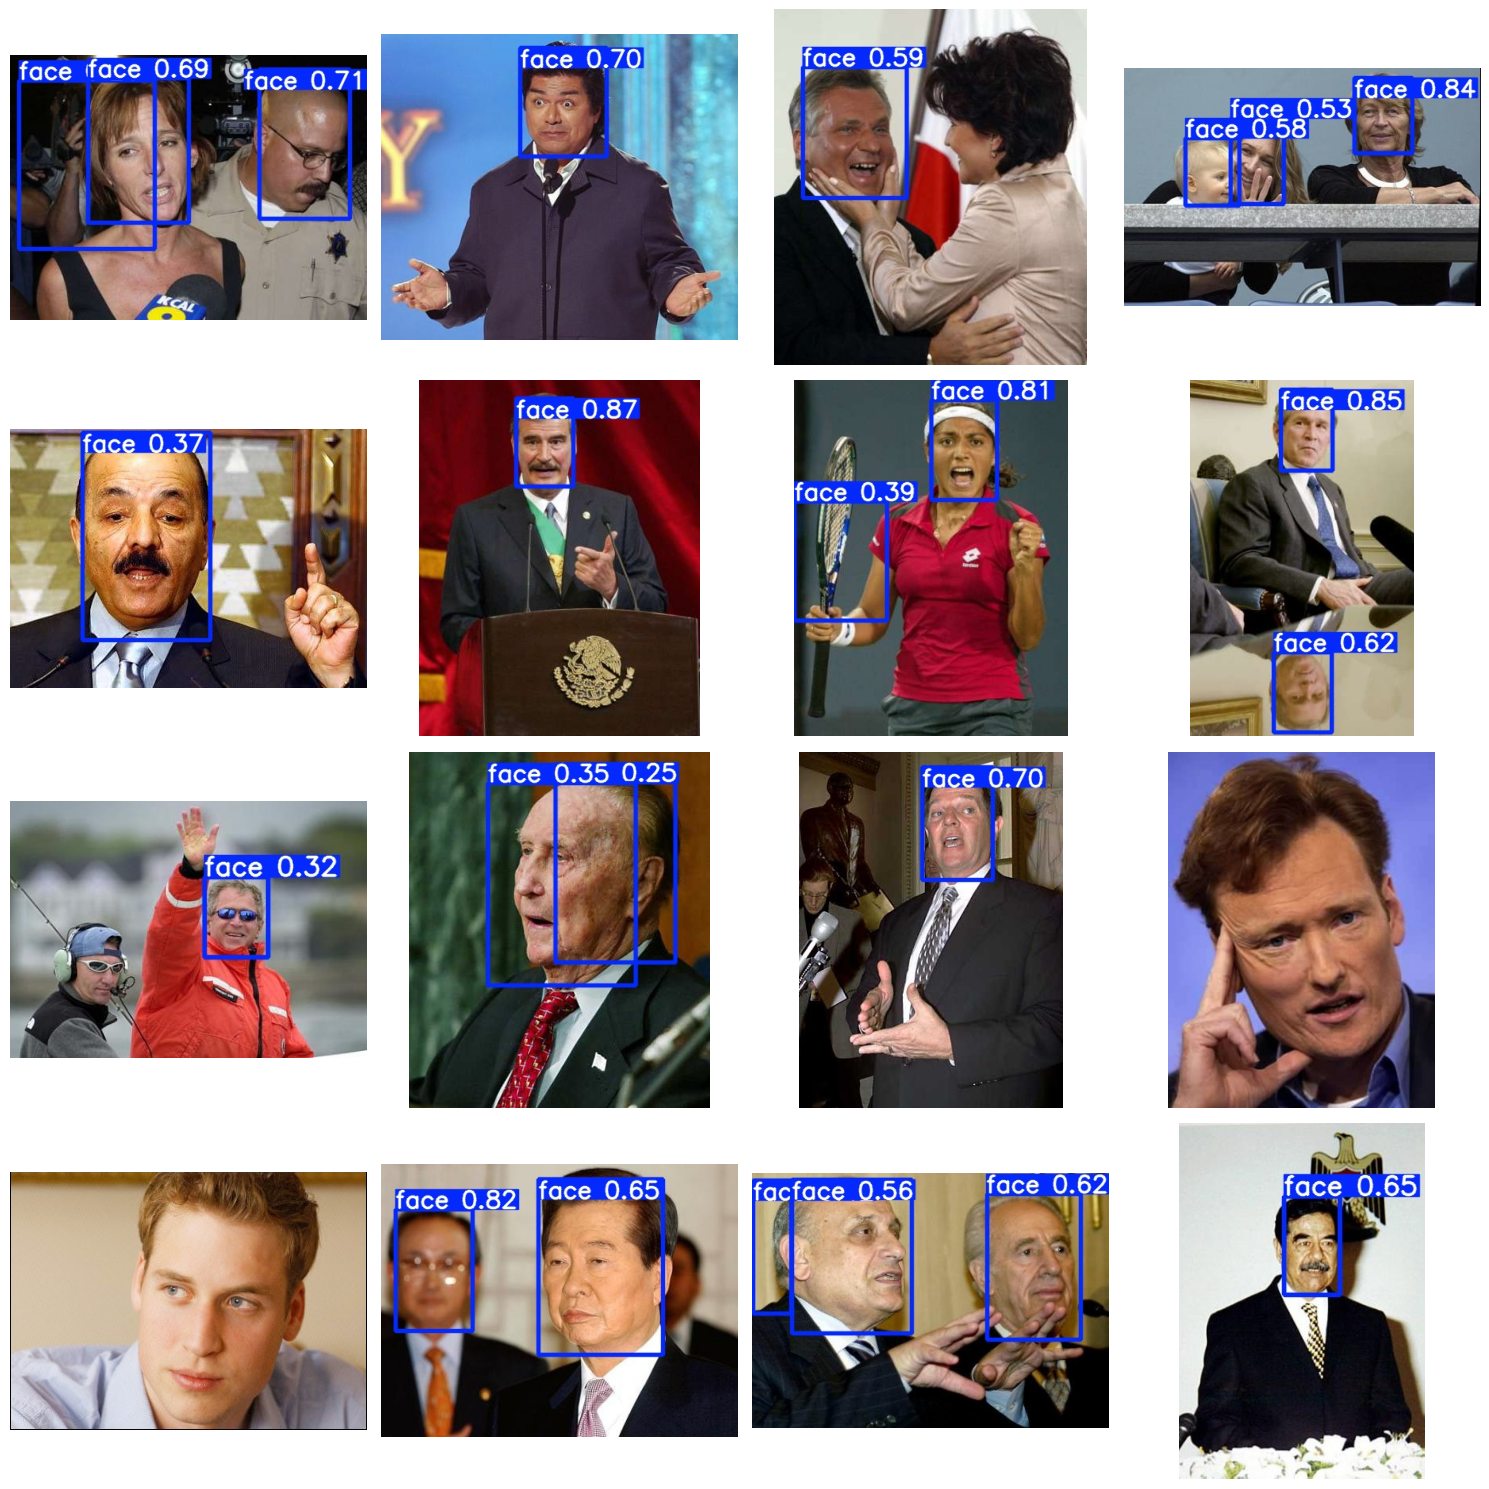

In [11]:
from PIL import Image as PILImage
# Set the directory where the result images are stored
result_dir = Path('/Users/ojas/Developer/AI/Projects/face_detection/yolov5/runs/detect/exp5')

# Get the first 16 images
image_paths = list(result_dir.glob('*.jpg'))[:16]

# Plot 16 images in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs = axs.flatten()

for img_path, ax in zip(image_paths, axs):
    img = PILImage.open(img_path)  
    ax.imshow(np.asarray(img))
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


### Saving the model

In [3]:
# Load the YOLOv5 model
model_path = 'yolov5/runs/train/exp5/weights/best.pt' 
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

Using cache found in /Users/ojas/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-7 Python-3.10.14 torch-2.4.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### Testing the model live using CV2 and webcam

In [ ]:
import cv2

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame = cv2.flip(frame, 1)
    resized_frame = cv2.resize(frame, (320, 320))
    # Run YOLOv5 inference
    results = model(frame)

    # Get predictions
    preds = results.pandas().xyxy[0]  # Get predictions in a DataFrame

    # Loop through each detection
    for _, row in preds.iterrows():
        confidence = row['confidence']  # Confidence score of the detection
        if confidence > 0.0:  # Only draw if confidence is greater than 0.5
            x_min, y_min, x_max, y_max = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            # Draw green bounding box
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            # Draw label with confidence
            label = f"{row['name']} ({confidence:.2f})"
            cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('YOLOv5 Face Detection', frame)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869:

### Testing the model with some random images from the internet

In [6]:
files_and_dirs = os.listdir(os.getcwd())

# Print the list
print(files_and_dirs)

['test_images', '.DS_Store', 'notebook.ipynb', 'yolov5m.pt', 'yolov5l.pt', 'yolov5', 'yolov5s.pt', '.ipynb_checkpoints', 'dataset.yaml', 'data']


In [5]:
os.chdir('..')

In [15]:
# Directory with test images
test_images_folder = 'test_images'

# Get list of image files
image_files = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display images with bounding boxes
for img_path in image_files:
    # Open the image
    img = Image.open(img_path)
    img_rgb = img.convert('RGB')

    # Make predictions
    results = model(img_rgb)

    # Get bounding boxes and labels
    boxes = results.xyxy[0].cpu().numpy()  # Bounding boxes (x_min, y_min, x_max, y_max)

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box[:4])
        draw.rectangle([x_min, y_min, x_max, y_max], outline='green', width=2)  # Green box

    # Display the image
    img.show()

/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/Users/ojas/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:869: